In [1]:
import sys
import time
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display

In [3]:
import RPi.GPIO as GPIO
GPIO.setmode(GPIO.BCM)

In [4]:
from PID import PID

In [5]:
RELAY_PIN = 21
GPIO.setup(RELAY_PIN, GPIO.OUT)

In [6]:
DEVICE_ID='28-0000057b4685'
DEVICE_FILE='/sys/bus/w1/devices/%s/w1_slave' % (DEVICE_ID)

In [7]:
DEVICE_ID_rect='28-0000075bcfcf'
DEVICE_FILE_rect='/sys/bus/w1/devices/%s/w1_slave' % (DEVICE_ID_rect)

In [8]:
def read_temp():
    try:
        with open(DEVICE_FILE) as f:
            lines = f.readlines()
        temp = lines[1].split('t=')[1]
        return float(temp) / 1000
    except e:
        return -1

In [9]:
def read_temp_bottom():
    try:
        with open(DEVICE_FILE_rect) as f:
            lines = f.readlines()
        temp = lines[1].split('t=')[1]
        return float(temp) / 1000
    except e:
        return -1

In [10]:
def turn_heater_on():
    GPIO.output(RELAY_PIN, GPIO.HIGH)

def turn_heater_off():
    GPIO.output(RELAY_PIN, GPIO.LOW)

In [11]:
def get_log_file_name(myEpoc, words=[]):
    t = time.strptime(time.ctime(myEpoc))
    #return time.strftime('%Y%m%d%H%M%S') + '.csv'
    t_string = "{:04d}{:02d}{:02d}{:02d}{:02d}{:02d}".format(t.tm_year,t.tm_mon,t.tm_mday,t.tm_hour,t.tm_min,t.tm_sec)
    if len(words)>0:
        fname = t_string + '_' + '_'.join(words)
    else:
        fname = t_string
    return fname + '.csv'

In [12]:
def output(power):
    '''
    powerは0〜1の実数値
    '''
    #print("power: {}".format(power))
    if power > 1:
        power = 1
    if power < 0:
        power = 0
    on = power * 10
    off = (1 - power) * 10
    if on > 0:
        turn_heater_on()
        #print("on: {}".format(on))
        time.sleep(on)
    if off > 0:
        turn_heater_off()
        #print("off: {}".format(off))
        time.sleep(off)

In [13]:
read_temp()

27.937

In [14]:
turn_heater_off()

# Run

In [15]:
targetTemperature = 60.0 # target water temperature in degrees C
cookTime = 90 # minutes to cook for

In [16]:
Kp = 2.7
Ki = 0.005
Kd = 0.001

In [17]:
pid = PID(Kp, Ki, Kd)

In [18]:
pid.SetPoint = targetTemperature

Fished cooking!
Cooking completed


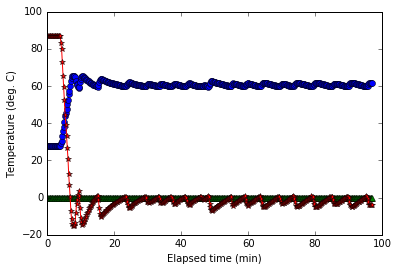

In [19]:
fname = get_log_file_name(time.time(), [str(Kp), str(Ki), str(Kd)])
start_epoc = time.time()

x = []
y = []
y2 = []
pw = []
hitTarget = False # flag whether temperature has hit the target once
timeForTarget = 0 # seconds took to hit target temperature for the first time
fig = plt.figure()
while True:
    current_temp = read_temp()
    #current_temp_bottom = read_temp_bottom()
    current_temp_bottom = 0
    sec_elapsed = time.time() - start_epoc
    # record time to hit target temperature for the fist time
    if (not hitTarget) & (current_temp > pid.SetPoint):
        hitTarget = True
        timeForTarget = sec_elapsed
    # break while loop after cooking for the cookTime
    if sec_elapsed > (cookTime*60 + timeForTarget):
        print("Fished cooking!")
        break
    pid.update(current_temp)
    power = pid.output
    P = pid.PTerm
    I = pid.Ki * pid.ITerm
    D = pid.Kd * pid.DTerm
    with open(fname, 'a') as f:
        f.write(",".join([str(int(sec_elapsed)),str(current_temp),str(power),str(current_temp_bottom),
                         str(P), str(I), str(D)])+"\n")
    x.append(sec_elapsed)
    y.append(current_temp)
    y2.append(current_temp_bottom)
    pw.append(power)
    fig.clear()
    ax = fig.add_subplot(111)
    ax.plot(np.array(x)/60,y, '-o', label='temperature')
    ax.plot(np.array(x)/60,y2, '-^', label='temperature2')
    ax.plot(np.array(x)/60,pw, '-*', label='control')
    ax.set_xlabel('Elapsed time (min)')
    ax.set_ylabel('Temperature (deg. C)')
    display.display(fig)
    msg = "Time: {:.2f}(min), Temperature: {:.1f}(deg C), Power: {:.2f}, Temp_bottom: {:.1f}".format(sec_elapsed/60, current_temp, power, current_temp_bottom)
    msg += ", P: {:.2f}, I: {:.2f}, D: {:.2f}".format(P,I,D)

    print(msg)
    display.clear_output(wait=True)
    output(power)
#print(y)
print("Cooking completed")